In [25]:
import pandas as pd
import numpy as np
import matplotlib as plt
import os

In [26]:
# Define the path to the directory containing the train.csv
dir_path = "/kaggle/input/fiu-cap5610-spring-2023"
file_name = "train.csv"
# Join the directory path and the file name
path = os.path.join(dir_path, file_name)
# Read the file using pandas. Read the train CSV file containing the CAPTCHA image IDs and their labels
captcha_id = pd.read_csv(path)
# Display the first few (5) rows of the dataframe
captcha_id.head()

,id,class
0,1276,C3
1,1333,C3
2,3011,A3
3,3950,B0
4,685,A0


In [27]:
# Convert the 'id' column to string type
captcha_id['id'] = captcha_id['id'].astype('str')

In [28]:
# Define the path to the directory containing the CAPTCHA images
dir_path = "/kaggle/input/fiu-cap5610-spring-2023"
file_name = "images"
# Join the directory path and the file name
image_path = os.path.join(dir_path, file_name)

In [29]:
# Initialize an empty dictionary to store the CAPTCHA images and their labels
captcha_data = {}
# Import necessary libraries
from PIL import Image
import cv2
# Initialize an empty list to store individual letters
letters = []
# Loop over each CAPTCHA image in the training set
for c_id,c_class in captcha_id.values:
    # Load the CAPTCHA image
    captcha = Image.open(f"{image_path}/{c_id}.png")
    # Convert the image to grayscale
    captcha = captcha.convert('L')
    # Convert the image to a numpy array
    captcha = np.array(captcha)
    # Apply Otsu's thresholding to binarize the image
    _,cap_thresh = cv2.threshold(captcha,0,255,cv2.THRESH_OTSU)
    # Apply morphological transformations to remove noise and separate the characters
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    
    cap_eroded = cv2.erode(cap_thresh,kernel,iterations = 1)
    
    cap_dilated = cv2.dilate(cap_eroded,kernel,iterations = 1)
    
    cap_morphed = Image.fromarray(cap_dilated)
    # Find the contours of the characters in the image
    contours, _ = cv2.findContours(cap_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
    # Loop over the contours
    for contour in contours:
        # Get the bounding box of the contour
        x, y, w, h = cv2.boundingRect(contour)
        # Crop the letter from the CAPTCHA
        letter_cap = cap_morphed.crop((x, y, x+w, y+h))
        # Resize the letter to 28x28 pixels
        letter_cap_resized = letter_cap.resize((28, 28))
        # Convert the letter to a NumPy array
        letter_cap_arr = np.array(letter_cap_resized)#.flatten()
        # Store the letter and its corresponding label in the captcha_data dictionary
        captcha_data[c_id] = {'image':letter_cap_arr,'label':c_class}
        # Append the letter array to the letters list
        letters.append(letter_cap_arr)


In [30]:
# Extract the features and labels from captcha_data
features = [captcha_data[key]['image'] for key in captcha_data.keys()]
labels = [captcha_data[key]['label'] for key in captcha_data.keys()]

In [31]:
# Split the dataset into training and validation sets
from sklearn.model_selection import train_test_split

train_images,val_images,train_labels,val_labels = train_test_split(features,labels, test_size=0.25, random_state=42)
# Reshape the image arrays
train_images = np.array(train_images).reshape((-1, 28, 28, 1))
val_images = np.array(val_images).reshape((-1, 28, 28, 1))
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)



In [32]:
# Convert labels to numerical values (Encode the label arrays as numerical values)
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)



In [33]:
# Define the convolutional neural network model architecture
#Import the TensorFlow library
import tensorflow as tf
#Define a sequential model using the Keras API of TensorFlow.
model = tf.keras.Sequential([
#Add a 2D convolutional layer with 32 filters, 3x3 kernel size, ReLU activation function, and input shape of 28x28x1.
tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
#Add a batch normalization layer to normalize the output of the previous layer.
tf.keras.layers.BatchNormalization(),
#Add another 2D convolutional layer with 32 filters, 3x3 kernel size, ReLU activation function.
tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
#Add another batch normalization layer to normalize the output of the previous layer.
tf.keras.layers.BatchNormalization(),
#Add a 2D convolutional layer with 32 filters, 5x5 kernel size, stride of 2, same padding, and ReLU activation function.
tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), strides=2, padding='same', activation='relu'),
#Add another batch normalization layer to normalize the output of the previous layer.
tf.keras.layers.BatchNormalization(),
#Add a dropout layer with a rate of 0.4 to prevent overfitting.
tf.keras.layers.Dropout(0.4),
# Add another 2D convolutional layer with 64 filters, 3x3 kernel size, ReLU activation function.
tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
#Add another batch normalization layer to normalize the output of the previous layer.
tf.keras.layers.BatchNormalization(),
#Add another 2D convolutional layer with 64 filters, 3x3 kernel size, ReLU activation function.
tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
#Add another batch normalization layer to normalize the output of the previous layer.
tf.keras.layers.BatchNormalization(),
#Add a 2D convolutional layer with 64 filters, 5x5 kernel size, stride of 2, same padding, and ReLU activation function.
tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), strides=2, padding='same', activation='relu'),
#Add another batch normalization layer to normalize the output of the previous layer.
tf.keras.layers.BatchNormalization(),
#Add a dropout layer with a rate of 0.4 to prevent overfitting.
tf.keras.layers.Dropout(0.4),
#Add another 2D convolutional layer with 128 filters, 4x4 kernel size, ReLU activation function.
tf.keras.layers.Conv2D(filters=128, kernel_size=(4, 4), activation='relu'),
# Add another batch normalization layer to normalize the output of the previous layer.
tf.keras.layers.BatchNormalization(),
#Add a flatten layer to flatten the output of the previous layer.
tf.keras.layers.Flatten(),
#Add a dropout layer with a rate of 0.4 to prevent overfitting.
tf.keras.layers.Dropout(0.4),
#Add a fully connected layer with 256
tf.keras.layers.Dense(256, activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(26, activation='softmax')
])



In [34]:
#Compile the model
model.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])



In [35]:
# Train the model
history = model.fit(train_images, train_labels, epochs=30, validation_data=(val_images, val_labels))

Epoch 1/30
94/94 [==============================] - 13s 102ms/step - loss: 3.8506 - accuracy: 0.0860 - val_loss: 2.7400 - val_accuracy: 0.1930
Epoch 2/30
94/94 [==============================] - 9s 97ms/step - loss: 2.6349 - accuracy: 0.2237 - val_loss: 1.4860 - val_accuracy: 0.5080
Epoch 3/30
94/94 [==============================] - 9s 97ms/step - loss: 1.7493 - accuracy: 0.4133 - val_loss: 0.8843 - val_accuracy: 0.6950
Epoch 4/30
94/94 [==============================] - 9s 91ms/step - loss: 1.1280 - accuracy: 0.5993 - val_loss: 0.6408 - val_accuracy: 0.7590
Epoch 5/30
94/94 [==============================] - 9s 93ms/step - loss: 0.6604 - accuracy: 0.7790 - val_loss: 0.2124 - val_accuracy: 0.9470
Epoch 6/30
94/94 [==============================] - 9s 92ms/step - loss: 0.4102 - accuracy: 0.8680 - val_loss: 0.1916 - val_accuracy: 0.9440
Epoch 7/30
94/94 [==============================] - 9s 99ms/step - loss: 0.2776 - accuracy: 0.9150 - val_loss: 0.0968 - val_accuracy: 0.9760
Epoch 8/30


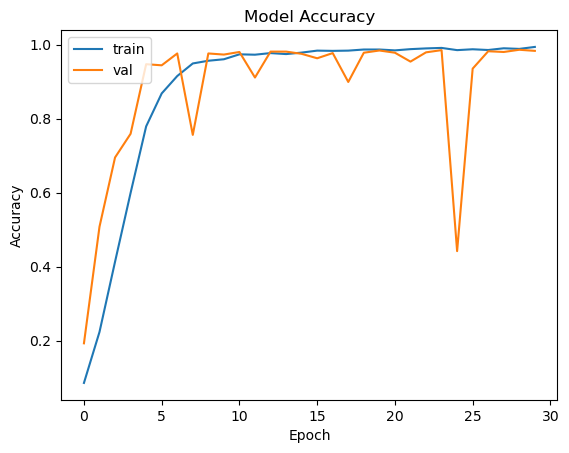

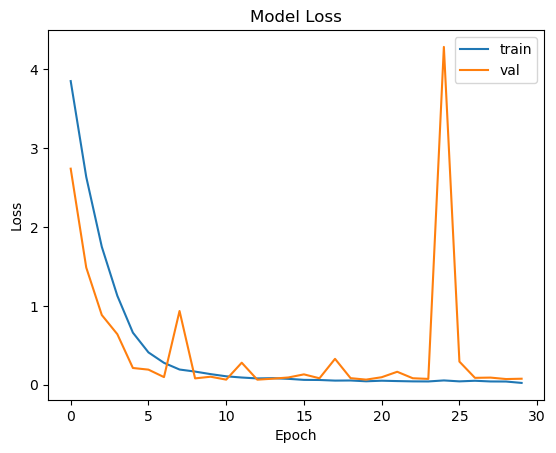

In [36]:
# Plot the training and validation accuracy and loss
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [37]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_images, val_labels)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

32/32 [==============================] - 1s 19ms/step - loss: 0.0763 - accuracy: 0.9830
Validation Loss: 0.07626090943813324
Validation Accuracy: 0.9829999804496765


In [38]:
# Define the path to the directory containing the test.csv
dir_path = "/kaggle/input/fiu-cap5610-spring-2023"

file_name = "test.csv"
# Join the directory path and the file name
test_path = os.path.join(dir_path, file_name)
# Read the file using pandas. Read the test CSV file containing the CAPTCHA image IDs 
captcha_test = pd.read_csv(test_path)
# Display the first few (5) rows of the dataframe
captcha_test.head()

,id
0,3991
1,1337
2,83
3,2688
4,4363


In [39]:
# Convert the 'id' column to string type
captcha_test['id'] = captcha_test['id'].astype('str')

In [40]:
# Define the path to the directory containing the CAPTCHA images
dir_path = "/kaggle/input/fiu-cap5610-spring-2023"
file_name = "images"
# Join the directory path and the file name
image_path = os.path.join(dir_path, file_name)


In [41]:
# Import necessary libraries
from PIL import Image
import cv2
# Initialize an empty dictionary to store the CAPTCHA images and their labels
test_captcha_data = {}
for c_id in captcha_test['id']:
    # Load the CAPTCHA image
    captcha = Image.open(f"{image_path}/{c_id}.png")
    # Convert the image to grayscale
    captcha = captcha.convert('L')
    # Convert the image to a numpy array
    captcha = np.array(captcha)
    # Apply Otsu's thresholding to binarize the image
    _,cap_thresh = cv2.threshold(captcha,0,255,cv2.THRESH_OTSU)
    # Apply morphological transformations to remove noise and separate the characters
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    
    cap_eroded = cv2.erode(cap_thresh,kernel,iterations = 1)
    
    cap_dilated = cv2.dilate(cap_eroded,kernel,iterations = 1)
    
    cap_morphed = Image.fromarray(cap_dilated)
    # Find the contours of the characters in the image
    contours, _ = cv2.findContours(cap_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
    
    letters = []
    # Loop over the contours
    for contour in contours:
        # Get the bounding box of the contour
        x, y, w, h = cv2.boundingRect(contour)
        # Crop the letter from the CAPTCHA
        letter_cap = cap_morphed.crop((x, y, x+w, y+h))
        # Resize the letter to 28x28 pixels
        letter_cap_resized = letter_cap.resize((28, 28))
        # Convert the letter to a NumPy array
        letter_cap_arr = np.array(letter_cap_resized)#.flatten()
        
        test_captcha_data[c_id] = letter_cap_arr
    
    test_images = np.array(list(test_captcha_data.values())).reshape((-1, 28, 28, 1))
    


In [42]:
#Predicting the Test set data
predictions_test = model.predict(test_images)

32/32 [==============================] - 1s 22ms/step


In [43]:
#Converting the predictions to classes
predicted_test_labels = label_encoder.inverse_transform(predictions_test.argmax(axis=1))

In [44]:
# Save predictions
for i, c_id in enumerate(captcha_test['id']):
    captcha_test.at[i, 'class'] = predicted_test_labels[i]

In [45]:
# Save predicted labels to a CSV file
captcha_test.to_csv('submission2.csv', index=False)